# Local Binary Pattern - SVM & RF (with PCA)


In [1]:
from keras.models import Sequential

import tensorflow as tf

import tensorflow_datasets as tfds
from skimage import feature


from tensorflow.keras.models import load_model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, adam
from keras.utils import np_utils
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
from numpy import *
from PIL import Image


# **Load Data & Data Preprocessing**
*  Randomly shuffling train_data
*  Image Resizing
*  Image Rescaling

In [2]:
import os
import cv2
import numpy as np

dataset_path = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"
CATEGORIES = ["Ipsala", "Basmati", "Karacadag"]
IMG_SIZE = 200
MAX_IMAGES_PER_CLASS = 5000  # Limit the number of images per class

training = []

def TrainingData():
    for i, category in enumerate(CATEGORIES):
        path = os.path.join(dataset_path, category)
        print(path)
        class_num = CATEGORIES.index(category)
        
        image_count = 0  # Keep track of the number of images collected for this class
        for img in os.listdir(path):
            if image_count >= MAX_IMAGES_PER_CLASS:
                break  # Stop collecting images once the limit is reached
            
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training.append([new_array, class_num])
            image_count += 1

# Call the TrainingData() function to process the dataset
TrainingData()


/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Ipsala
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Basmati
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag


In [3]:
len(training)

15000

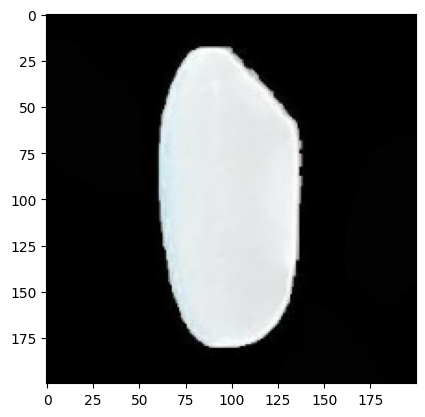

0


In [4]:
plt.imshow(training[0][0])
plt.show()
print(training[0][1])

In [5]:
random.shuffle(training)

In [6]:
X =[]
y =[]
for features, label in training:
  X.append(features)
  y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

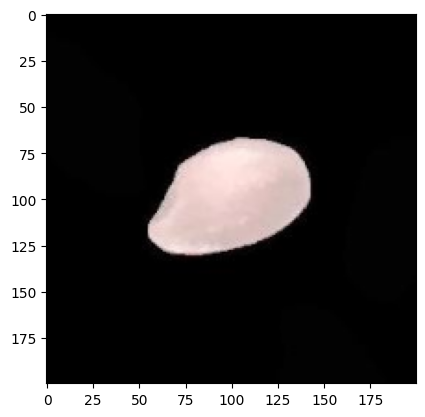

In [7]:
plt.imshow(X[0])
plt.show()

[0. 0. 1.]


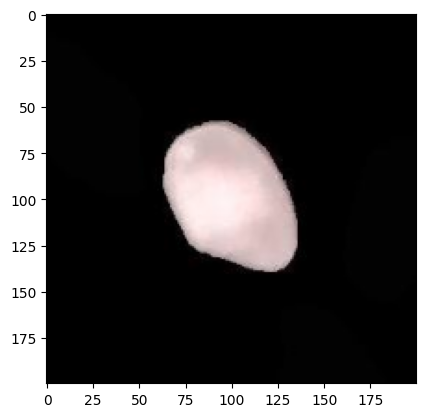

In [8]:
from keras.utils import np_utils
Y = np_utils.to_categorical(y, 3)
print(Y[1])
plt.imshow(X[1])
plt.show()

In [9]:
def extract_lbp_features(image):
    lbp_radius = 1
    lbp_points = 8 * lbp_radius

    # Ensure the image is in the range [0, 1]
    image = image.astype(np.float32)
    
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Extract LBP features
    lbp = feature.local_binary_pattern(gray_image, lbp_points, lbp_radius, method='uniform')
    
    # Resize LBP features to the same size as the input image (200x200)
    lbp_resized = cv2.resize(lbp, (200, 200), interpolation=cv2.INTER_LINEAR)

    return lbp_resized

In [10]:
X_lbp = []
for image in X:
    temp = extract_lbp_features(image)
    X_lbp.append(temp)


/opt/conda/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [11]:
len(X_lbp)

15000

In [12]:
print(X_lbp[1])
lbp_radius = 1
lbp_points = 8 * lbp_radius


[[8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 ...
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]]


In [13]:
lbp_vis = X_lbp[1].astype(np.uint8) * (255 / (lbp_points + 2))


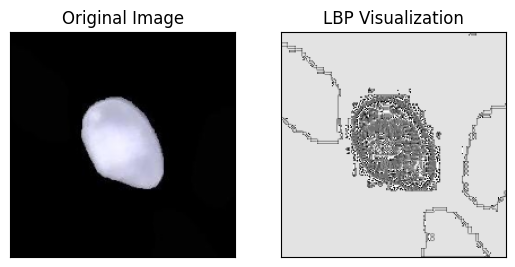

In [14]:
plt.subplot(121), plt.imshow(cv2.cvtColor(X[1], cv2.COLOR_BGR2RGB), cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(lbp_vis, cmap='gray')
plt.title('LBP Visualization'), plt.xticks([]), plt.yticks([])
plt.show()

# **Split Dataset**

In [15]:
X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp = train_test_split(X_lbp, y, test_size = 0.2, random_state = 3)

In [16]:
X_train_lbp = np.array(X_train_lbp)
X_test_lbp = np.array(X_test_lbp)
y_train_lbp = np.array(y_train_lbp)
y_test_lbp = np.array(y_test_lbp)

(200, 200)


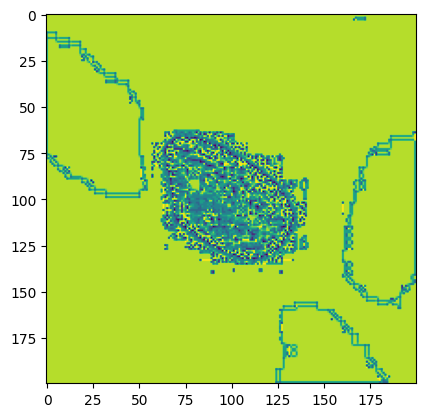

2


In [17]:
print(X_test_lbp[1].shape)
plt.imshow(X_test_lbp[1])  
plt.show()
print(y_test_lbp[1])

In [18]:
X_train_lbp = X_train_lbp.reshape((X_train_lbp.shape[0],200*200))
X_test_lbp = X_test_lbp.reshape((X_test_lbp.shape[0],200*200))

In [19]:
from sklearn.svm import SVC  # Import the Support Vector Classifier (SVC)
from sklearn.ensemble import RandomForestClassifier  # Import the Random Forest Classifier

# Create and train an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train_lbp, y_train_lbp)

# Create and train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_lbp, y_train_lbp)

# Predict the class using SVM
svm_prediction = svm_classifier.predict(X_test_lbp)

# Predict the class using Random Forest
rf_prediction = rf_classifier.predict(X_test_lbp)

print("SVM Predictions:", svm_prediction)
print("Random Forest Predictions:", rf_prediction)


SVM Predictions: [2 2 1 ... 1 0 1]
Random Forest Predictions: [2 2 1 ... 1 0 1]


In [20]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Create SVM and Random Forest classifiers
svm_classifier = SVC(kernel='linear', C=1.0)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the classifiers
svm_classifier.fit(X_train_lbp, y_train_lbp)
rf_classifier.fit(X_train_lbp, y_train_lbp)

RandomForestClassifier(random_state=0)

# # SVM and Random forest accuracy

In [21]:
from sklearn.metrics import accuracy_score

svm_predictions = svm_classifier.predict(X_test_lbp)
rf_predictions = rf_classifier.predict(X_test_lbp)

svm_accuracy = accuracy_score(y_test_lbp, svm_predictions)
rf_accuracy = accuracy_score(y_test_lbp, rf_predictions)

print("SVM Accuracy:", svm_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

SVM Accuracy: 0.999
Random Forest Accuracy: 0.9983333333333333


# SVM Accuracy: 0.9993333333333333
# # Random Forest Accuracy: 0.9986666666666667

# ======================================================================================================


# 2) # Hough Feature | SVM & RF 

/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Ipsala
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Basmati
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag


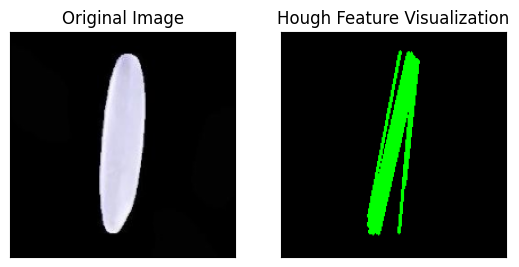

In [22]:
import os
import cv2
import numpy as np
import random
from keras.utils import np_utils

dataset_path = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"
CATEGORIES = ["Ipsala", "Basmati", "Karacadag"]
IMG_SIZE = 200
MAX_IMAGES_PER_CLASS = 500  # Limit the number of images per class

training = []

def TrainingData():
    for i, category in enumerate(CATEGORIES):
        path = os.path.join(dataset_path, category)
        print(path)
        class_num = CATEGORIES.index(category)
        
        image_count = 0  # Keep track of the number of images collected for this class
        for img in os.listdir(path):
            if image_count >= MAX_IMAGES_PER_CLASS:
                break  # Stop collecting images once the limit is reached
            
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training.append([new_array, class_num])
            image_count += 1

# Call the TrainingData() function to process the dataset
TrainingData()

random.shuffle(training)

X = []
y = []
for features, label in training:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

Y = np_utils.to_categorical(y, 3)

def extract_hough_features(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply the Hough Line Transform
    lines = cv2.HoughLinesP(gray_image, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)
    
    # Create an image with the detected lines
    hough_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(hough_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Resize Hough features to the same size as the input image (200x200)
    hough_resized = cv2.resize(hough_image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    
    return hough_resized

X_hough = []
for image in X:
    temp = extract_hough_features(image)
    X_hough.append(temp)

# Now, X_hough contains Hough Line Transform features

# Visualize the original image and the Hough features
import matplotlib.pyplot as plt

plt.subplot(121), plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(X_hough[0], cv2.COLOR_BGR2RGB))
plt.title('Hough Feature Visualization'), plt.xticks([]), plt.yticks([])
plt.show()


# Applying SVM and Random Forest

(200, 200, 3)


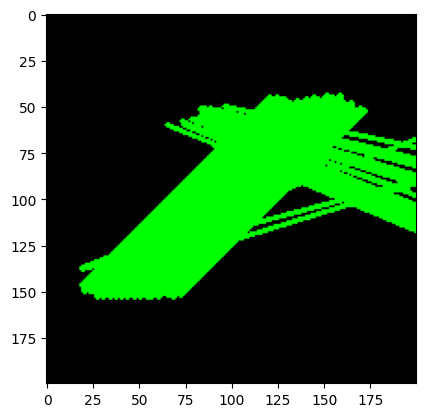

0
SVM Hough Prediction: [0]
Random Forest Hough Prediction: [0]
SVM Hough Accuracy: 0.9733333333333334
Random Forest Hough Accuracy: 0.9866666666666667


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split the Hough feature data into training and testing sets
X_train_hough, X_test_hough, y_train_hough, y_test_hough = train_test_split(X_hough, y, test_size=0.2, random_state=3)

X_train_hough = np.array(X_train_hough)
X_test_hough = np.array(X_test_hough)
y_train_hough = np.array(y_train_hough)
y_test_hough = np.array(y_test_hough)

print(X_test_hough[1].shape)
plt.imshow(cv2.cvtColor(X_test_hough[1], cv2.COLOR_BGR2RGB))
plt.show()
print(y_test_hough[1])

# Flatten the Hough features
X_train_hough = X_train_hough.reshape((X_train_hough.shape[0], IMG_SIZE * IMG_SIZE * 3))
X_test_hough = X_test_hough.reshape((X_test_hough.shape[0], IMG_SIZE * IMG_SIZE * 3))

# Create SVM and Random Forest classifiers
svm_classifier_hough = SVC(kernel='linear', C=1.0)
rf_classifier_hough = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the classifiers
svm_classifier_hough.fit(X_train_hough, y_train_hough)
rf_classifier_hough.fit(X_train_hough, y_train_hough)

# Predict the class using SVM for Hough features
svm_prediction_hough = svm_classifier_hough.predict([X_test_hough[1]])

# Predict the class using Random Forest for Hough features
rf_prediction_hough = rf_classifier_hough.predict([X_test_hough[1]])

print("SVM Hough Prediction:", svm_prediction_hough)
print("Random Forest Hough Prediction:", rf_prediction_hough)

# Evaluate the accuracies for Hough features
svm_predictions_hough = svm_classifier_hough.predict(X_test_hough)
rf_predictions_hough = rf_classifier_hough.predict(X_test_hough)

svm_accuracy_hough = accuracy_score(y_test_hough, svm_predictions_hough)
rf_accuracy_hough = accuracy_score(y_test_hough, rf_predictions_hough)

print("SVM Hough Accuracy:", svm_accuracy_hough)
print("Random Forest Hough Accuracy:", rf_accuracy_hough)


# SVM Hough Accuracy: 0.9533333333333334
# # Random Forest Hough Accuracy: 0.9633333333333334

# ***Applying PCA***

In [24]:
from sklearn.decomposition import PCA

# Define the number of components you want to keep after PCA
n_components = 100  # You can adjust this number

# Apply PCA to your Hough features
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_hough)
X_test_pca = pca.transform(X_test_hough)

# Create SVM and Random Forest classifiers for PCA-reduced features
svm_classifier_pca = SVC(kernel='linear', C=1.0)
rf_classifier_pca = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the classifiers with PCA-reduced features
svm_classifier_pca.fit(X_train_pca, y_train_hough)
rf_classifier_pca.fit(X_train_pca, y_train_hough)

# Evaluate the accuracies for PCA-reduced features
svm_predictions_pca = svm_classifier_pca.predict(X_test_pca)
rf_predictions_pca = rf_classifier_pca.predict(X_test_pca)

svm_accuracy_pca = accuracy_score(y_test_hough, svm_predictions_pca)
rf_accuracy_pca = accuracy_score(y_test_hough, rf_predictions_pca)

print("SVM PCA Accuracy:", svm_accuracy_pca)
print("Random Forest PCA Accuracy:", rf_accuracy_pca)


SVM PCA Accuracy: 0.97
Random Forest PCA Accuracy: 0.9666666666666667


# Accuracy changed
# 
# *SVM PCA Accuracy: 0.98
# Random Forest PCA Accuracy: 0.98*

# ==================================================================================================

# HoG Feature and SVM, Random Forest

/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Ipsala
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Jasmine
/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag


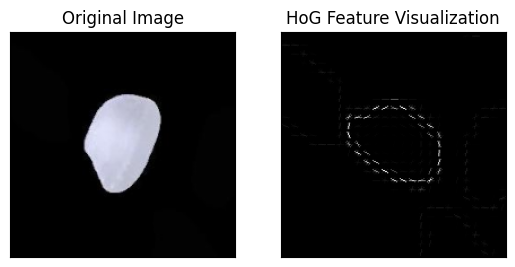

SVM HoG Prediction: [2]
Random Forest HoG Prediction: [2]
SVM HoG Accuracy: 0.9933333333333333
Random Forest HoG Accuracy: 0.9966666666666667


In [25]:
import os
import cv2
import numpy as np
import random
from keras.utils import np_utils
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

dataset_path = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"
CATEGORIES = ["Ipsala", "Jasmine", "Karacadag"]
IMG_SIZE = 200
MAX_IMAGES_PER_CLASS = 500  # Limit the number of images per class

training = []

def TrainingData():
    for i, category in enumerate(CATEGORIES):
        path = os.path.join(dataset_path, category)
        print(path)
        class_num = CATEGORIES.index(category)
        
        image_count = 0  # Keep track of the number of images collected for this class
        for img in os.listdir(path):
            if image_count >= MAX_IMAGES_PER_CLASS:
                break  # Stop collecting images once the limit is reached
            
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training.append([new_array, class_num])
            image_count += 1

# Call the TrainingData() function to process the dataset
TrainingData()

random.shuffle(training)

X = []
y = []
for features, label in training:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

Y = np_utils.to_categorical(y, 3)

def extract_hog_features(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Extract HoG features
    features, hog_image = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2-Hys', transform_sqrt=True, visualize=True)
    
    # Resize HoG features to the same size as the input image (200x200)
    hog_resized = cv2.resize(hog_image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    
    return hog_resized

X_hog = []
for image in X:
    temp = extract_hog_features(image)
    X_hog.append(temp)

# Now, X_hog contains HoG features

# Split the HoG feature data into training and testing sets
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(X_hog, y, test_size=0.2, random_state=3)

X_train_hog = np.array(X_train_hog)
X_test_hog = np.array(X_test_hog)
y_train_hog = np.array(y_train_hog)
y_test_hog = np.array(y_test_hog)

# Visualize the HoG features of an example image
plt.subplot(121), plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(X_test_hog[0], cmap='gray')
plt.title('HoG Feature Visualization'), plt.xticks([]), plt.yticks([])
plt.show()

# Flatten the HoG features
X_train_hog = X_train_hog.reshape((X_train_hog.shape[0], IMG_SIZE * IMG_SIZE))
X_test_hog = X_test_hog.reshape((X_test_hog.shape[0], IMG_SIZE * IMG_SIZE))

# Create SVM and Random Forest classifiers
svm_classifier_hog = SVC(kernel='linear', C=1.0)
rf_classifier_hog = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the classifiers
svm_classifier_hog.fit(X_train_hog, y_train_hog)
rf_classifier_hog.fit(X_train_hog, y_train_hog)

# Predict the class using SVM for HoG features
svm_prediction_hog = svm_classifier_hog.predict([X_test_hog[0]])

# Predict the class using Random Forest for HoG features
rf_prediction_hog = rf_classifier_hog.predict([X_test_hog[0]])

print("SVM HoG Prediction:", svm_prediction_hog)
print("Random Forest HoG Prediction:", rf_prediction_hog)

# Evaluate the accuracies for HoG features
svm_predictions_hog = svm_classifier_hog.predict(X_test_hog)
rf_predictions_hog = rf_classifier_hog.predict(X_test_hog)

svm_accuracy_hog = accuracy_score(y_test_hog, svm_predictions_hog)
rf_accuracy_hog = accuracy_score(y_test_hog, rf_predictions_hog)

print("SVM HoG Accuracy:", svm_accuracy_hog)
print("Random Forest HoG Accuracy:", rf_accuracy_hog)


# SVM HoG Accuracy: 0.975
# Random Forest HoG Accuracy: 0.9833333333333333

# Applying PCA on this

In [26]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# Initialize PCA with the desired number of components (e.g., n_components=50)
pca = PCA(n_components=50)

# Fit PCA on the training data and transform both the training and test data
X_train_pca = pca.fit_transform(X_train_lbp)
X_test_pca = pca.transform(X_test_lbp)


# Create and train an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train_pca, y_train_lbp)

# Create and train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_pca, y_train_lbp)

# Predict the class using SVM
svm_prediction = svm_classifier.predict(X_test_pca)

# Predict the class using Random Forest
rf_prediction = rf_classifier.predict(X_test_pca)

print("SVM Predictions:", svm_prediction)
print("Random Forest Predictions:", rf_prediction)

# Evaluate the accuracies for HoG features
svm_predictions_hog = svm_classifier_hog.predict(X_test_hog)
rf_predictions_hog = rf_classifier_hog.predict(X_test_hog)

svm_accuracy_hog = accuracy_score(y_test_hog, svm_predictions_hog)
rf_accuracy_hog = accuracy_score(y_test_hog, rf_predictions_hog)

print("SVM HoG Accuracy:", svm_accuracy_hog)
print("Random Forest HoG Accuracy:", rf_accuracy_hog)



SVM Predictions: [2 2 1 ... 1 0 1]
Random Forest Predictions: [2 2 1 ... 1 0 1]
SVM HoG Accuracy: 0.9933333333333333
Random Forest HoG Accuracy: 0.9966666666666667


# SVM HoG Accuracy: 0.9933333333333333
# # Random Forest HoG Accuracy: 0.9966666666666667